In [1]:
import deepchem as dc
import torch
from deepchem.models import GCNModel
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")
import torch.nn as nn

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clean_data = pd.read_csv(r"Data.csv")

In [3]:
data = clean_data

In [4]:
smiles = data.SMILES.to_list()
labels = data.LABELS.to_list()
        
featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
X = featurizer.featurize(smiles)
        
dataset = dc.data.NumpyDataset(X=X, y=labels)
        
torch_data = dataset.make_pytorch_dataset()

In [5]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [6]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data

    
    

In [7]:
dataset = BBBDataset(root=".",)

Processing...
3330it [00:02, 1366.47it/s]
Done!


In [109]:
from torch.utils.data import random_split
### Splitting of data
train_set, valid_set = random_split(dataset,[2331,999])
trainloader = DataLoader(train_set,shuffle=True,batch_size=512)
validloader = DataLoader(valid_set, shuffle=True,batch_size=512)
# testloader = DataLoader(test_set, shuffle=True,batch_size=256)

## Applying PyGCN

In [110]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [111]:
from dgl.nn import WeightAndSum
import torch.nn as nn
from torch_geometric.nn import GlobalAttention,GATConv
from torch_geometric.nn import global_add_pool,global_max_pool
from torch.nn import Sequential
import torch.nn.functional as F

In [112]:
class WeightedSumMax(nn.Module):
    """ Pooling layer"""
    
    def __init__(self,n_feats):
        super().__init__()
        
        self.n_feats = n_feats
        self.atom_weights = nn.Sequential(nn.Linear(n_feats, 1),
                                          nn.Sigmoid())
        
    def forward(self,x,batch):
        expanded_index = batch.unsqueeze(-1).expand(x.size())
        weights = self.atom_weights(x)
        weighted_feats = x*weights

        
        ## Loop to calculated weighted Sum
        prev_ind = 0
        expanded_data = []
        for i in Counter(pd.DataFrame(expanded_index)[0]).values(): ## features is 30 that's why last index is taken
            j = prev_ind + i
            extracted = torch.tensor(weighted_feats[prev_ind:j,:]) ## x replaced with weighted_feats
            summed = torch.sum(extracted,axis=0,keepdim=True) ## features of each nodes summed up
            maxed,index = torch.max(extracted,dim=0,keepdim=True) ## selecting the max 
            weighted= torch.cat([summed,maxed],dim=1) ## concating both
            expanded_data.append(weighted)
            prev_ind = prev_ind + i  
        
            _feats = torch.vstack(expanded_data)
        return _feats
        

In [151]:
class GATLayer(nn.Module):
    def __init__(self,in_feats,out_feats,n_heads=1,concat=True):
        super().__init__()
        
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.heads = n_heads
        
        ### Graph Layer
        self.GAT_conv = GATConv(in_channels=self.in_feats,out_channels=self.out_feats,
                                heads= self.heads,concat=concat,)
        
    
        ## Initiating Residual connection
        self.res_connection = nn.Linear(self.in_feats,self.out_feats*self.heads)
        
        
    def forward(self,x,edge_index):
        
        new_feats = self.GAT_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats
        new_feats =   F.dropout(input=new_feats,p=0.6,training=self.training) ## Dropout in each layer
        
        return new_feats
    
    

In [152]:
from torch_geometric.nn import global_mean_pool,global_max_pool
from collections import Counter

class PyGAT(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        """
        GAT layer with 3 attention head for each node.
        
        """
        
        ## Graph attention layer
        self.GAT_Conv1 = GATLayer(in_feats= 30,out_feats= 64,n_heads= 3,concat=True)
        self.GAT_Conv2 = GATLayer(in_feats= 192, out_feats= 16,n_heads = 1,)
        
        
        ## Pooling Layer
        self.weighted = WeightedSumMax(16) ## weighted SumAndMax
        
        
        ## Predictor Layer
        self.predict = nn.Sequential(
                        nn.Dropout(p=0.6,),
                        nn.Linear(16, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Linear(128, 1)
                                        )
        
    
                 
    def forward(self,data):
        
        ### Extracting data from batch
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        ### Stacking Layer
        x = self.GAT_Conv1(x=x,edge_index=edge_index)
        x = self.GAT_Conv2(x=x,edge_index=edge_index)
        
        x = global_max_pool(x,batch) ## Changed
#       x = self.weighted(x,batch) ## weighted sum
#       x = self.GlobalAtt(x,batch)
    
            
        ## Final predictor layer
        x = F.sigmoid(self.predict(x))
        
        return x

In [153]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGAT()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,)

### Defining loss
criterion = BCELoss()

### criterion
#criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device="cpu"
net.to(device)

PyGAT(
  (GAT_Conv1): GATLayer(
    (GAT_conv): GATConv(30, 64, heads=3)
    (res_connection): Linear(in_features=30, out_features=192, bias=True)
  )
  (GAT_Conv2): GATLayer(
    (GAT_conv): GATConv(192, 16, heads=1)
    (res_connection): Linear(in_features=192, out_features=16, bias=True)
  )
  (weighted): WeightedSumMax(
    (atom_weights): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (predict): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=16, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [154]:
from sklearn.metrics import accuracy_score
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [155]:
def train():
    
    net.train()
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)

In [156]:
@torch.no_grad()
def test(loader):
    net.eval()
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    return (val,accuracy)

In [158]:
epochs = 300

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train()
    
    train_loss2,train_accuracy2 = test(trainloader)
    
    val_loss,val_accuracy = test(validloader)
    
#     test_loss,test_accuracy = test(testloader)
    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
#     test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
#     teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

Epoch: 001, Train loss: 0.5062, Train accuracy: 0.7580, val loss: 0.9426, val accuracy: 0.5856


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (299,) and (1,)

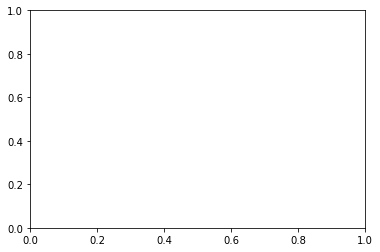

In [159]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

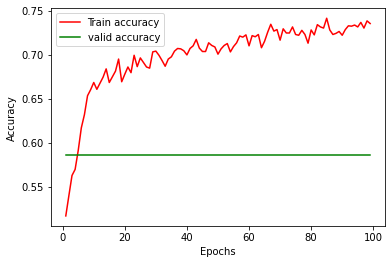

In [150]:
plt.plot([i for i in range(1,epochs)],[i for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[i  for i in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


### Saving Model

In [188]:
torch.save(net,"model-GCN")

In [189]:
model1 = torch.load("model-GCN")

In [187]:
model1.eval()
model1.to("cpu")
model1([*testloader][4])

tensor([[0.4506]], grad_fn=<SigmoidBackward0>)